In [441]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader



In [442]:
# Veri setini yükle
data = pd.read_csv('/Users/canergiden/Desktop/MAC/Ağ Programlama /Veri Seti/heart-disease.csv')

In [443]:
# Verileri önişleme (örneğin, standart ölçeklendirme)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [444]:
# Graf oluşturma
G = nx.Graph()

In [445]:
# Düğümleri ekle (örneğin, özellikler)
for column in data.columns:
    G.add_node(column, type='feature')

In [446]:
# Kenarları ekle
for i, row in data.iterrows():
    for column, value in row.items():
        G.add_node(value, type='value')
        G.add_edge(column, value)

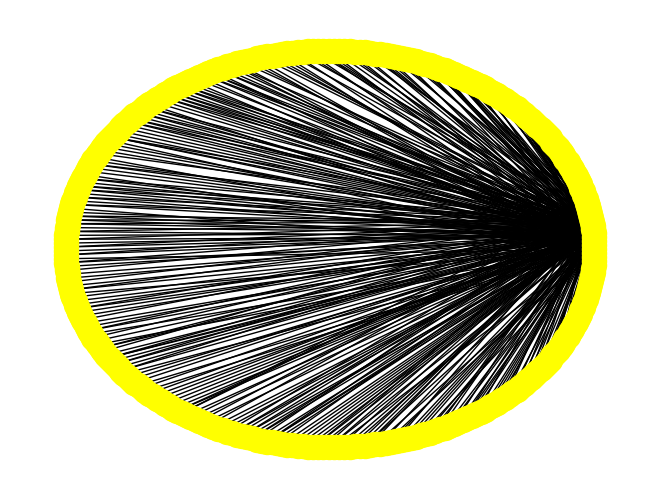

In [447]:
pos = nx.circular_layout(G)
labels = {node: G.nodes[node]['label'] if 'label' in G.nodes[node] else '' for node in G.nodes}
nx.draw(G, pos, with_labels=True,labels = labels,node_color="yellow")
plt.show()

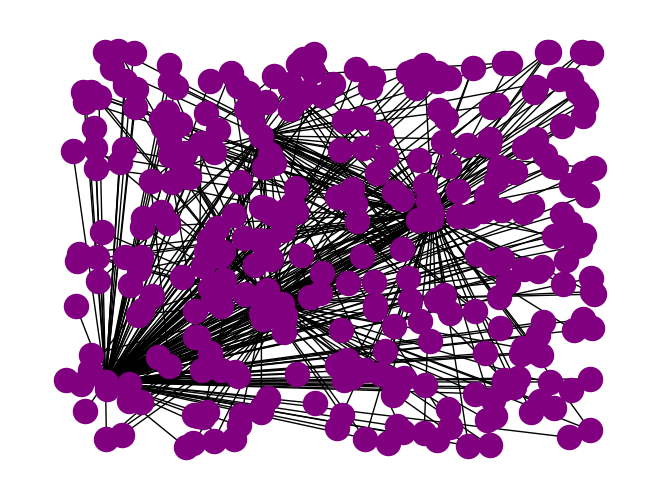

In [448]:
pos = nx.random_layout(G)
labels = {node: G.nodes[node]['label'] if 'label' in G.nodes[node] else '' for node in G.nodes}
nx.draw(G, pos, with_labels=True,labels = labels,node_color="purple")
plt.show()

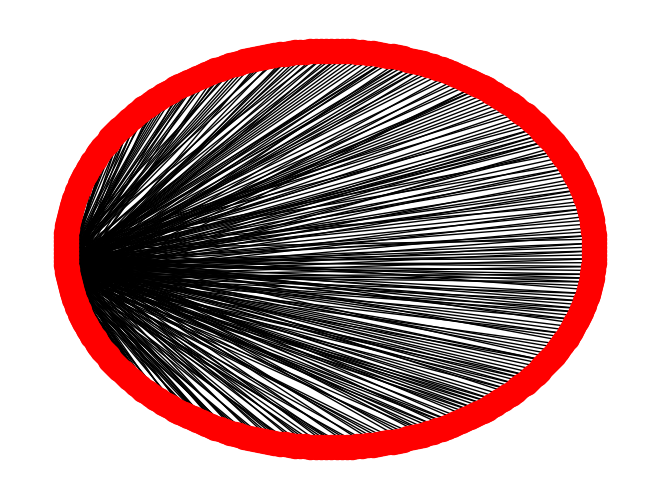

In [449]:
pos = nx.shell_layout(G)
labels = {node: G.nodes[node]['label'] if 'label' in G.nodes[node] else '' for node in G.nodes}
nx.draw(G, pos, with_labels=True,labels = labels,node_color="red")
plt.show()

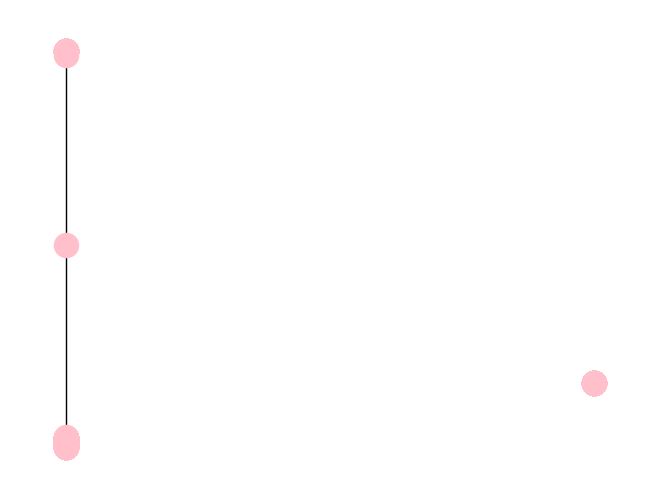

In [450]:
pos = nx.spectral_layout(G)
labels = {node: G.nodes[node]['label'] if 'label' in G.nodes[node] else '' for node in G.nodes}
nx.draw(G, pos, with_labels=True,labels = labels,node_color="pink")
plt.show()

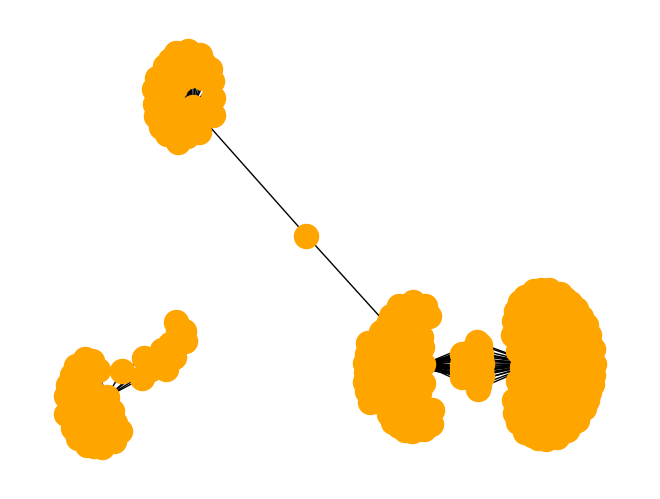

In [451]:
# Grafı görselleştirme (opsiyonel)
pos = nx.spring_layout(G)
labels = {node: G.nodes[node]['label'] if 'label' in G.nodes[node] else '' for node in G.nodes}
nx.draw(G, pos, with_labels=True,labels = labels,node_color="orange")
plt.show()

In [452]:
# Grafı GNN modeli için hazırlama
node_features = torch.eye(len(data.columns))  # Her özellik için bir birim matris oluştur


In [453]:
# Düğüm adlarını sayısal düğüm endekslerine dönüştürme
node_mapping = {node: i for i, node in enumerate(G.nodes)}
edges = [(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]


In [454]:
# Kenarları tensor formatına dönüştürme
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = node_features.view(-1, 1)
y = torch.tensor([0, 1])  # Örnek etiketler

In [455]:
# PyTorch Geometric veri yapısını oluşturma
data = Data(x=x, edge_index=edge_index, y=y)

In [456]:
data

Data(x=[196, 1], edge_index=[2, 400], y=[2])

In [457]:
transform = RandomLinkSplit(num_val=0.1, num_test=0.1)

train_data, val_data, test_data = transform(data)


In [458]:
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels=len(data.x), out_channels=16)  # 16 gizli birim
        self.conv2 = GCNConv(in_channels=16, out_channels=2)  # 2 çıkış birimi (örnek için)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [464]:
# Modeli oluşturma, optimizasyonu ve eğitimi
model = GNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.transforms import RandomLinkSplit

In [ ]:
# Eğitim ve test veri yükleyicilerini oluşturma
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

/opt/homebrew/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Eğitim fonksiyonu
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        for data in val_loader:
            out = model(data)
            val_loss += criterion(out, data.y).item()
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')

In [ ]:
# Modeli eğitme
train_model(model, criterion, optimizer, train_loader, val_loader)